# Swiss Super League - xG vs. xGOT

## Imports

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, NoNorm
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np

from PIL import Image
import urllib
import json
import os

In [2]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")

## Read the data

In [3]:
df = pd.read_csv('data/swiss_xgot_09122022.csv', index_col=0)
df.head()

,match_id,date,referee,variable,value,venue,team_id,team_name,team_lineup
1,3905399,2022-07-17 09:30:00,Lukas Fähndrich,xG_for,0.75,H,9777,Servette,4 - 3 - 3
2,3905399,2022-07-17 09:30:00,Lukas Fähndrich,xGOT_for,0.58,H,9777,Servette,4 - 3 - 3
27,3905400,2022-07-17 09:30:00,Fedayi San,xG_for,2.12,H,7896,Lugano,4 - 3 - 3
28,3905400,2022-07-17 09:30:00,Fedayi San,xGOT_for,2.59,H,7896,Lugano,4 - 3 - 3
53,3905394,2022-07-24 09:30:00,NaN,xG_for,0.98,H,9956,Grasshopper,3 - 1 - 4 - 2


In [4]:
df = df.groupby(['team_name', 'team_id', 'variable']).sum().reset_index()

In [13]:
df = df.pivot(index=['team_name', 'team_id'], columns=['variable'], values='value').reset_index()

In [16]:
df = df.sort_values(by=['xG_for']).reset_index(drop=True)

## Create color map for gradient

In [14]:
colors = [
    '#efe9e6',
    '#e9e1dd',
    '#e3dad3',
    '#dcd3c9',
    '#d4ccc0',
    '#ccc6b7',
    '#c3bfae',
    '#bab9a6',
    '#b0b39e',
    '#a6ad96',
    '#9ba790',
    '#90a18a',
    '#849b84',
    '#789680',
    '#6c907c',
    '#608a79',
    '#538476',
    '#467e74',
    '#387872',
    '#287271',
]
soc_cm = LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

In [63]:
df['diff'] = df['xGOT_for'] - df['xG_for']

## The Visual

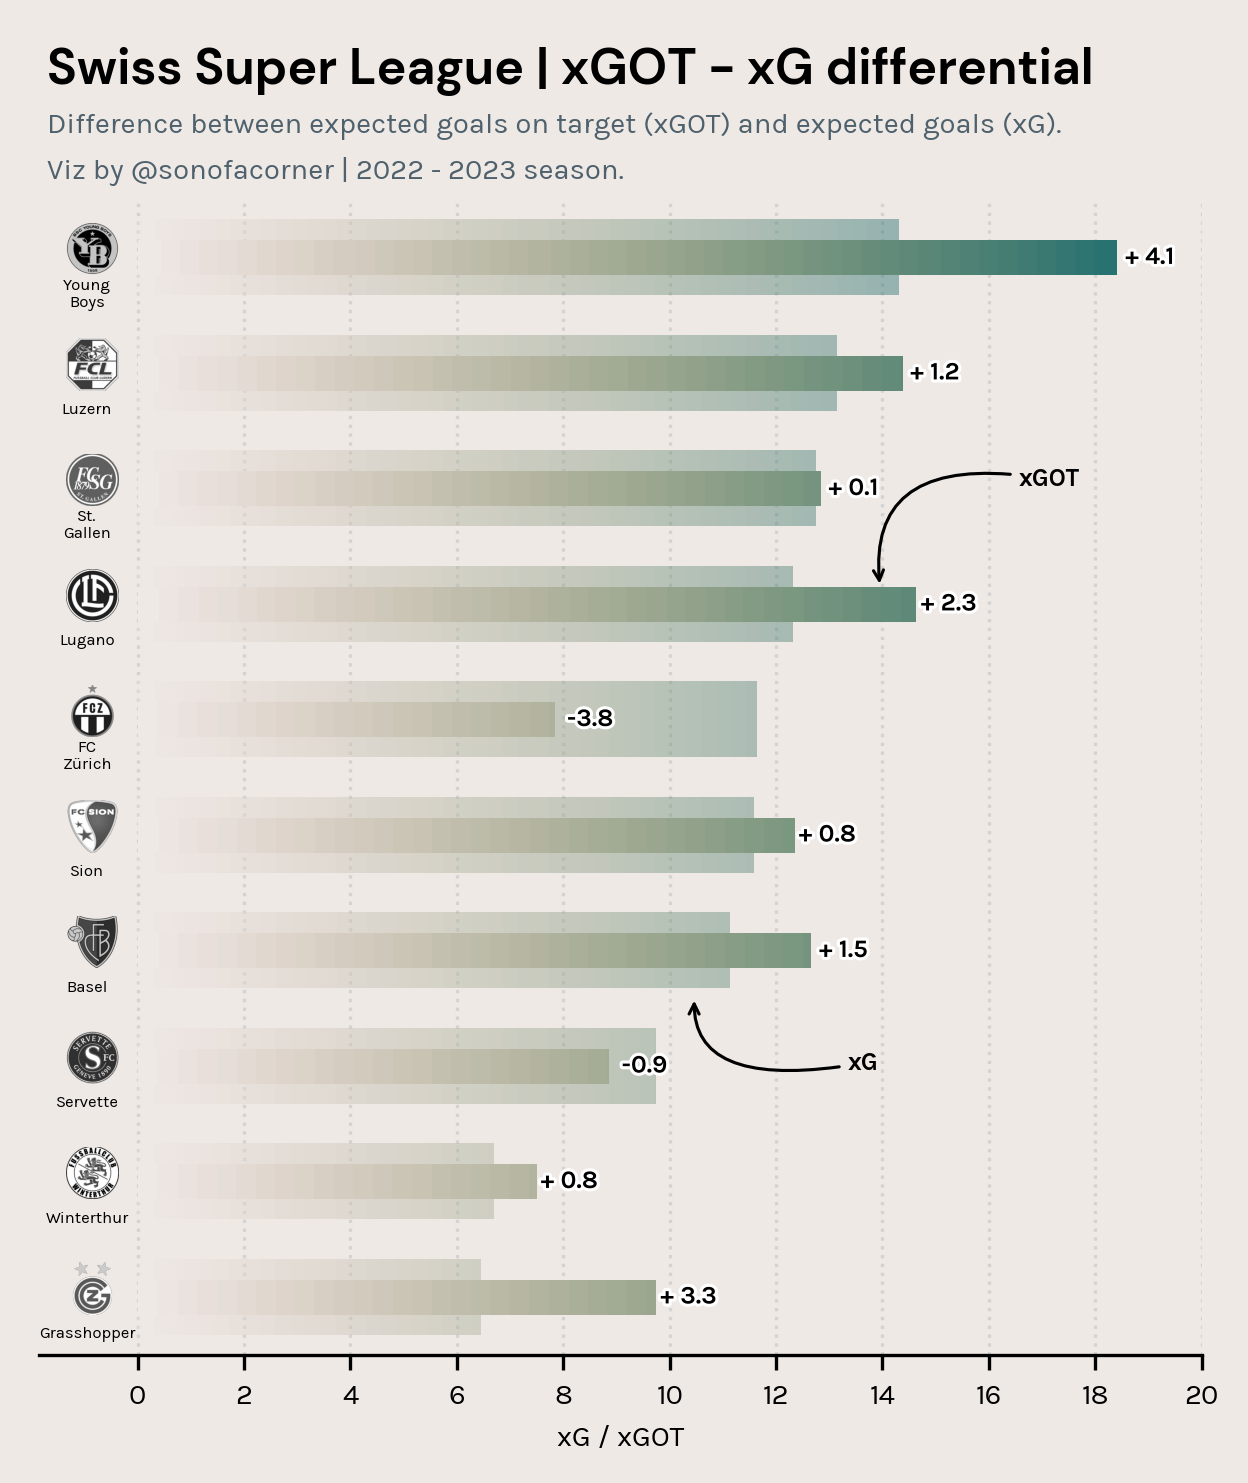

In [101]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax = plt.subplot(111)

ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_label_text('xG / xGOT', size=7)
ax.tick_params(labelsize=7)
ax.grid(axis='x', color='lightgrey', ls=':')
# xG
bars_ = ax.barh(df.index, df['xG_for'], height=0.65)
for bar in bars_:
    bar.set_zorder(1)
    bar.set_facecolor('none')
    x,y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    grad = np.atleast_2d(np.linspace(0,1*w/max(df['xG_for']),256))
    ax.imshow(
        grad, extent=[x,x+w,y,y+h], 
        aspect='auto', zorder=3, 
        norm=NoNorm(vmin=0,vmax=1), cmap='SOC', alpha=0.45
    )
# xGOT
bars_ = ax.barh(df.index, df['xGOT_for'], height=0.3)
lim = ax.get_xlim()+ax.get_ylim()
for bar in bars_:
    bar.set_zorder(1)
    bar.set_facecolor('none')
    x,y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    grad = np.atleast_2d(np.linspace(0,1*w/max(df['xGOT_for']),256))
    ax.imshow(
        grad, extent=[x,x+w,y,y+h], 
        aspect='auto', zorder=3, 
        norm=NoNorm(vmin=0,vmax=1), cmap='SOC'
    )

ax.set_xlim(-1.85,20)
ax.set_ylim(-.5,9.5)
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
for y in df.index:
    ax_coords = DC_to_NFC((-1.35,y-.15))
    team_id = df['team_id'].iloc[y]
    team_name = df['team_name'].iloc[y].replace(' ', '\n')
    diff_xg = df['diff'].iloc[y]
    xGOT = df['xGOT_for'].iloc[y]
    if diff_xg > 0:
        text_sign = '+'
    else:
        text_sign = ''
    ax_size = 0.035
    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None', anchor='C'
    )
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    player_face = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id}.png")).convert('LA')
    image_ax.imshow(player_face)
    image_ax.axis("off")
    ax.annotate(
        xy=(-.95, y - .32),
        text=team_name,
        size=4,
        ha='center',
        va='center'
    )
    text_ = ax.annotate(
        xy=(xGOT, y),
        xytext=(8,0),
        text=f'{text_sign} {diff_xg:.1f}',
        size=6,
        ha='center',
        va='center',
        textcoords='offset points',
        weight='bold'
    )
    text_.set_path_effects(
        [path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()]
    )


text_ = ax.annotate(
    xy=(14, 6),
    xytext=(40,30),
    text='xGOT',
    size=6,
    ha='center',
    va='center',
    textcoords='offset points',
    weight='bold',
    arrowprops=dict(
            arrowstyle="->", shrinkA=0, shrinkB=5, color="black", linewidth=0.75,
            connectionstyle="angle3,angleA=-10,angleB=100"
    )
)

text_ = ax.annotate(
    xy=(10.5, 2.75),
    xytext=(40,-20),
    text='xG',
    size=6,
    ha='center',
    va='center',
    textcoords='offset points',
    weight='bold',
    arrowprops=dict(
            arrowstyle="->", shrinkA=0, shrinkB=5, color="black", linewidth=0.75,
            connectionstyle="angle3,angleA=10,angleB=-100"
    )
)


fig_text(
    x = 0.13, y = .95, 
    s = "Swiss Super League | xGOT - xG differential",
    va = "bottom", ha = "left",
    fontsize = 12, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.13, y = .89, 
    s = "Difference between expected goals on target (xGOT) and expected goals (xG).\nViz by @sonofacorner | 2022 - 2023 season.",
	va = "bottom", ha = "left",
	fontsize = 7, color = "#4E616C", font = "Karla"
)

plt.savefig(
	"figures/09122022_swiss_xg_xgot.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/09122022_swiss_xg_xgot_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)